In [ ]:
from pathlib import Path
import time

import pandas as pd
import geopandas as gpd

from nird.utils import load_config
import nird.road_revised as func

import json
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")
base_path = Path(load_config()["paths"]["base_path"])

## Base scenario passenger flow simulation (2021, Great Britain)

In this example, we developed a process-based network flow model to simulate passenger car flows across the GB road networks (including only major and minor roads, excluding local tertiary roads). For demonstration purposes and to minimise computational requirements, we randomly sampled 1,000 travel records, using Output Area (OA) regions to represent the origins and destinations of local trips. 

The model employs an iterative method to simulate the congested equilibrium flow assignment process, accounting for road capacities. A speed-flow relationship is embedded to predict variations in traffic speeds as vehicle volumes increase, incorporating maximum and minimum speed limits.

The model outputs flow patterns (i.e., road_links) and associated travel costs, including tolls, vehicle operational costs, and time-equivalent costs (i.e., odpfc). It also identifies trip isolations caused by network disconnectivity (i.e., isolation). 

##### Data Preparation (including: model parameters, road network elements, and OD flow data)

In [ ]:
# Prepare model parameters
with open(base_path / "parameters" / "flow_breakpoint_dict.json", "r") as f:
    flow_breakpoint_dict = json.load(f)
with open(base_path / "parameters" / "flow_cap_plph_dict.json", "r") as f:
    flow_capacity_dict = json.load(f)
with open(base_path / "parameters" / "free_flow_speed_dict.json", "r") as f:
    free_flow_speed_dict = json.load(f)
with open(base_path / "parameters" / "min_speed_cap.json", "r") as f:
    min_speed_dict = json.load(f)
with open(base_path / "parameters" / "urban_speed_cap.json", "r") as f:
    urban_speed_dict = json.load(f)

In [ ]:
# Prepare OD flow data
od_node_2021 = pd.read_csv(
    base_path
    / "census_datasets"
    / "od_matrix"
    / "od_gb_oa_2021_node_with_bridges.csv"
)
od_node_2021["Car21"] = od_node_2021["Car21"] * 2 # to acount for round trip
od_node_2021.head()

,origin_node,destination_node,Car21
0,00005379-C865-4196-BFE6-A3F7CBBBC84E,14B1C0EF-D058-4D9A-A44A-99B23FF5851B,2
1,00005379-C865-4196-BFE6-A3F7CBBBC84E,3FB03056-BA28-4F12-B51F-7FC48AA9DE99,2
2,00005379-C865-4196-BFE6-A3F7CBBBC84E,4E4697E7-916B-4C73-B130-260E078F8DAA,2
3,00005379-C865-4196-BFE6-A3F7CBBBC84E,7504E505-25B7-4288-AF5D-7A77B81A1E4C,2
4,00005379-C865-4196-BFE6-A3F7CBBBC84E,90A6D710-0599-4DF3-AED9-2C88B232461F,2


In [ ]:
# Prepare road link data
road_link_file = gpd.read_parquet(
    base_path / "networks" / "road" / "GB_road_links_with_bridges.gpq"
)
road_links = func.edge_init(
    road_link_file,
    flow_capacity_dict,
    free_flow_speed_dict,
    urban_speed_dict,
    min_speed_dict,
    max_flow_speed_dict=None,
)

In [ ]:
# Create igraph network
network = func.create_igraph_network(road_links)

In [ ]:
network # network is a undirected graph

In [ ]:
network.es.attributes() # check the attributes of the edges

['e_id', 'weight', 'time_cost', 'operating_cost', 'average_toll_cost']

In [ ]:
network.vs.attributes() # check the attributes of the nodes

['name']

In [ ]:
# run flow simulation
"""The simulation with full OD data takes about 3 days to finish.
    To test the function, we randomly select 1000 OD pairs from the full dataset for demosntration.
"""
start_time = time.time()
od_node_2021_sample = od_node_2021.sample(n=1000, random_state=2, ignore_index=True)
(
    road_links,
    isolation,
    odpfc,
) = func.network_flow_model(
    road_links,
    network,
    od_node_2021_sample,
    flow_breakpoint_dict,
    num_of_cpu = 1, # set the number of CPU cores as 1 for testing
)
end_time = time.time()
print(f"Time taken for simulation: {end_time - start_time} seconds")

The initial supply is 2518
The initial number of edges in the network: 505750
The initial number of origins: 994
The initial number of destinations: 989
No.1 iteration starts:
The least-cost path flow allocation time: 21.8218035697937.
Non_allocated_flow: 90
The remaining number of origins: 988
The remaining number of destinations: 983
The maximum amount of edge overflow: -52798.0
Iteration stops: there is no edge overflow! with 96.42573471008737% flows sent to the network!
The flow simulation is completed!
total travel cost is (£): 15657.299921531234
total time-equiv cost is (£): 11159.594426235144
total operating cost is (£): 4462.30549529609
total toll cost is (£): 35.4
Time taken for simulation: 24.52324151992798 seconds


In [ ]:
isolation = pd.DataFrame(
    isolation,
    columns=[
        "origin_node",
        "destination_node",
        "flow",
    ],
)
isolation.head()

,origin_node,destination_node,flow
0,2393B52C-FF0B-4678-810B-AB6BCC5FCB1B,2393B52C-FF0B-4678-810B-AB6BCC5FCB1B,2
1,8440B278-03F4-49DB-8054-61E4DB833F9A,3920230E-29B9-4E4F-81E4-DBD376A3EDDC,2
2,25EF0C0D-E2C7-4076-AC16-A7A9203A5412,3920230E-29B9-4E4F-81E4-DBD376A3EDDC,2
3,0F94B2D8-6907-4327-8DA1-B4A604D05CDE,0F94B2D8-6907-4327-8DA1-B4A604D05CDE,4
4,CD33211E-598E-4476-80E1-AC815AD22ED9,515A13C6-70FA-4A0E-B018-FE1B0473B35B,2


In [ ]:
odpfc = pd.DataFrame(
    odpfc,
    columns=[
        "origin_node",
        "destination_node",
        "path",
        "flow",
        "operating_cost_per_flow",
        "time_cost_per_flow",
        "toll_cost_per_flow",
    ],
)
odpfc.head()

,origin_node,destination_node,path,flow,operating_cost_per_flow,time_cost_per_flow,toll_cost_per_flow
0,E1F5EA74-57AB-479B-AF90-9EA8AF6A43D6,84B25C4C-DA38-4EED-8F2C-F962B2650128,"[roade_265903, roade_265902, roade_265901, roa...",2,0.565523,1.811828,0.0
1,B9B6F29B-BC84-4B06-BF9B-F1A21DDA1607,79EC8AB2-DAF3-492D-A588-771556707BF2,"[roade_206483, roade_87773, roade_128242, road...",4,0.680072,2.078496,0.0
2,24D4B66B-6DA8-435D-BC2C-C68C3EBDE5D0,8FB347AA-975A-4CC0-85C0-59560BB9887F,"[roade_18032, roade_222722, roade_131062, road...",2,0.839693,2.559878,0.0
3,30BB3A7A-7FEB-44BB-BC9B-E36359887937,D9A6E691-DF68-419C-8B2D-84ECC50C764C,"[roade_96002, roade_164788, roade_68512, roade...",2,0.307913,0.988440,0.0
4,3105C38B-5A76-480E-9A35-4C4D2905F5FA,409E40A3-CC95-4303-A7E9-82C0C28D6450,"[roade_32922, roade_30616, roade_252557, roade...",2,1.808045,5.525207,0.0


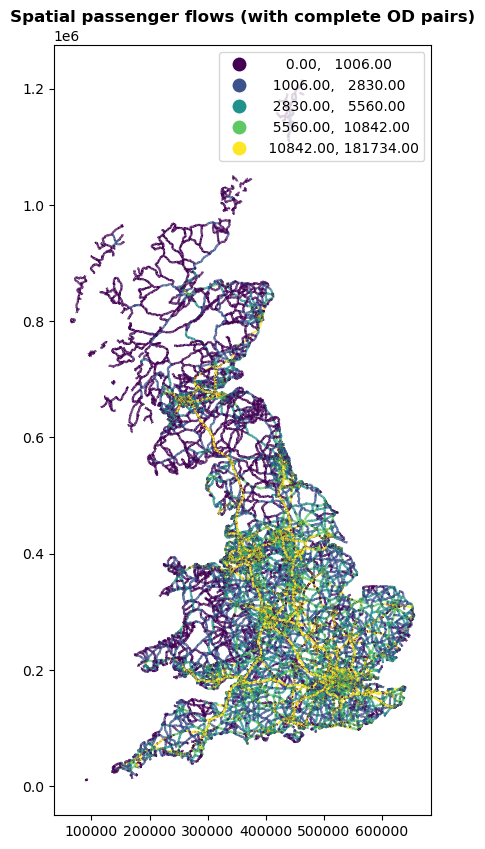

In [ ]:
# load the spatial simulation results based on complete OD pairs
road_links_with_full_od = gpd.read_parquet(base_path.parent / "outputs"/"base_scenario"/"edge_flows_visualisation.pq")
ax = road_links_with_full_od.plot(
    column='acc_flow',
    cmap='viridis',
    legend=True,
    figsize=(8, 10),
    scheme='quantiles',  # or 'natural_breaks', 'equal_interval'
    k=5  # number of classes
)
plt.title('Spatial passenger flows (with complete OD pairs)', weight='bold')
plt.show()